In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
df = pd.read_csv('recipe_text.csv')
df.head()

,title,ingredients,ingredient
0,Baked Haddock,milk,milk
1,Baked Haddock,salt,salt
2,Baked Haddock,bread crumbs,bread
3,Baked Haddock,grated parmesan cheese,parmesan cheese
4,Baked Haddock,ground dried thyme,thyme


# Topic Modeling

## LDA using sklearn

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [239]:
# combine ingred into one
df_lda = df_text.groupby('title')['ingredient'].apply(' '.join).reset_index()
df_lda.head()

,title,ingredient
0,A Scotsmans Shepherd Pie,boiled potato sour cream cream cheese butter s...
1,A Simply Perfect Roast Turkey,turkey unsalted butter softened salt black pep...
2,Absolute Best Liver And Onions,beef liver milk needed butter vidalia onion ri...
3,Accidental Fish,mahi mahi olive oil salted butter garlic lemon...
4,Actually Delicious Turkey Burgers,turkey bread onion egg white parsley garlic sa...


In [108]:
# initialize tfidf 
vec = CountVectorizer()
vec_matrix = vec.fit_transform(df_lda.ingredient)

In [109]:
vec_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [110]:
# initialize and fit LDA 
lda = LDA(n_components=10)
lda.fit(vec_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [111]:
lda_matrix = lda.transform(vec_matrix)

In [112]:
lda_matrix

array([[0.53957212, 0.25359468, 0.00243947, ..., 0.00243967, 0.00243938,
        0.0024397 ],
       [0.5280268 , 0.39923994, 0.00909147, ..., 0.00909192, 0.00909228,
        0.00909118],
       [0.72890297, 0.00769442, 0.00769393, ..., 0.2095462 , 0.00769494,
        0.00769428],
       ...,
       [0.00454636, 0.31004958, 0.06760341, ..., 0.47265835, 0.0045463 ,
        0.00454681],
       [0.50061835, 0.08241442, 0.00312562, ..., 0.00312605, 0.00312579,
        0.32773357],
       [0.00833699, 0.00833602, 0.00833896, ..., 0.00833472, 0.00833776,
        0.00833422]])

In [113]:
def print_topics(lda, vectorizer, top_n):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(lda.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-top_n - 1:-1]]))

In [115]:
print("Topics found via LDA:")
print_topics(lda, vec, 20)

Topics found via LDA:

Topic #0:
pepper salt black onion oil garlic beef water butter cayenne broth sauce olive red tomato vegetable needed rosemary celery bay

Topic #1:
pepper butter salt cheese garlic parsley olive oil lemon black cream parmesan deveined shrimp heavy white italian onion egg wine

Topic #2:
pepper chicken cumin broth powder flour lime chipotle chili beef tortilla dressing corn black onion salt vegetable roast cilantro breast

Topic #3:
cheese tomato garlic onion pepper sauce parmesan salt mozzarella egg black pasta jar beef olive basil cream oil oregano italian

Topic #4:
salt pepper mustard pork black dijon sauce vinegar powder garlic roast sugar brown apple cider rib barbeque shoulder cayenne worcestershire

Topic #5:
sauce soy oil rice sesame green garlic vinegar hot onion white sugar paste pepper vegetable seed ginger asian wine brown

Topic #6:
sauce sugar brown pepper soy garlic ginger vegetable onion powder oil white pork water root ketchup salt vinegar beef j

In [116]:
columns = []
for i in range(1, 11):
    columns.append('topic_' + str(i))

In [117]:
# create a new df
df_topic = pd.DataFrame(lda_matrix, index=df_lda.title.tolist(), columns=columns)

In [124]:
df_topic.topic_1.sort_values(ascending=False)[:20]
# topic_1 looks more like Meat dish

Chef Johns Cassoulet                                         0.985481
How To Make Cassoulet                                        0.982349
Chef Johns Face Pie                                          0.980846
Tourtiere French Canadian Meat Pie                           0.979540
Dirty Dirty Rice                                             0.976309
Short Rib And Cauliflower Curry                              0.972717
Chef Johns Roast Turkey And Gravy                            0.970965
Peppercorn Roast Beef                                        0.970962
Beef Bourguignon I                                           0.968959
Cotechino And Braised Beans                                  0.968959
Sous Vide New York Strip Steak                               0.967852
Midwest Salisbury Steak                                      0.966659
Lamb Meatballs And Sauce                                     0.966659
Instant Pot Salisbury Steak With Onion And Mushroom Gravy    0.966657
Coconut Milk Corned 

In [126]:
df_topic.topic_2.sort_values(ascending=False)[:20]
# topic_2 looks more like Seafood dish

Shrimp Scampi With Pasta                                0.969996
Cajun Seafood Pasta                                     0.965379
Exchange Gang Pasta With Shrimp                         0.963995
Gourmet Mushroom Risotto                                0.959081
Ultimate Shrimp Scampi                                  0.959080
Chef Johns Prison Style Meatloaf                        0.959079
Shrimp Lemon Pepper Linguini                            0.957136
Grilled Pattypan Squash With Hot Chorizo Vinaigrette    0.957130
Spaghetti With Clam Sauce                               0.954993
Lobster Newberg                                         0.952628
Almond Crusted Tilapia                                  0.952623
Shrimp And Asparagus                                    0.952622
Instant Mac And Cheese                                  0.952620
Fish Roll Ups                                           0.949989
Shrimp Linguine                                         0.947053
Ham And Cheese Quiche    

In [128]:
df_topic.topic_3.sort_values(ascending=False)[:20]
# topic_3 looks more like Mexican cuisine

Kris Amazing Shredded Mexican Beef                             0.962490
Slow Cooker Pinto Beans                                        0.954989
Mississippi Pot Roast                                          0.952627
Slow Cooker Pot Roast                                          0.949990
Original Homemade Italian Beef                                 0.924987
Ronaldos Beef Carnitas                                         0.918158
Slow Cooker Italian Beef                                       0.909991
Blat Wraps                                                     0.909983
Mississippi Roast   Slow Cooker Pepperoncini Pot Roast         0.909982
Honey Glazed Ham                                               0.887460
Chicken And Mushroom Chimichangas                              0.827063
Three Packet Slow Cooker Roast                                 0.792376
Pork Carnitas                                                  0.640828
Chipotle Shrimp Tacos                                          0

In [129]:
df_topic.topic_4.sort_values(ascending=False)[:20]
# topic_4 looks more like Italian cuisine

Alysias Basic Meat Lasagna                 0.967851
Spinach Lasagna Iii                        0.965379
Pizza Without The Red Sauce                0.962491
Hearty Vegetable Lasagna                   0.959084
Spinach And Feta Pita Bake                 0.957138
Spinach Cheese Manicotti                   0.957137
Four Cheese Margherita Pizza               0.954993
Spinach Lasagna Ii                         0.952626
Jalapeno Popper Grilled Cheese Sandwich    0.952619
Three Cheese Manicotti                     0.949995
Stuffed Shells Iii                         0.949994
Taco Stuffed Shells                        0.949991
Lasagna Roll Ups                           0.947056
Baked Ziti Iii                             0.947055
Manicotti                                  0.947052
Spaghetti Squash Casserole In The Shell    0.947048
Baked Ziti I                               0.943746
Three Cheese Baked Pasta                   0.943746
Three Cheese Manicotti Ii                  0.939996
Bats And Cob

In [130]:
df_topic.topic_5.sort_values(ascending=False)[:20]
# topic_5 looks more like Pork dish

Chef Johns Pumpkin Braised Pork                  0.962489
Bourbon Mango Pulled Pork                        0.960863
Southern Grilled Barbecued Ribs                  0.959081
Herbed Pork And Apples                           0.959081
Slow Cooker Carolina Bbq                         0.957135
Pork Chops With Apple Cider Glaze                0.957133
Barbecued Beef                                   0.954993
Quick Savory Cranberry Glazed Pork Loin Roast    0.954991
Apple Cider Sauce And Pork Loin Chops            0.954988
Maple Glazed Ribs                                0.943745
Spoiled Baby Back Ribs                           0.943745
Barbeque Pork Two Ways                           0.935701
Simple Bbq Ribs                                  0.918171
Kalua Pig In A Slow Cooker                       0.909995
Prime Rib                                        0.909991
Simple Savory Pork Roast                         0.909990
Grilled Pork Tenderloin                          0.909986
Salmon With Br

In [131]:
df_topic.topic_6.sort_values(ascending=False)[:20]
# topic_6 looks more like Korean cuisine

Grilled Korean Style Beef Short Ribs             0.967854
Korean Bbq Short Ribs Gal Bi                     0.962493
Kalbi Korean Bbq Short Ribs                      0.952625
Awesome Korean Steak                             0.949996
Miso Maple Glazed Salmon                         0.947051
Sesame Beef                                      0.935705
Spicy Eggplant                                   0.896391
Korean Bbq Beef Pul Kogi                         0.829929
Easy Korean Ground Beef Bowl                     0.757585
Beef Bulgogi                                     0.732876
Korean Barbecued Rack Of Lamb                    0.731522
Lovers Beef Burgundy Filet                       0.728278
Halibut With Rice Wine                           0.721038
Root Beer And Sesame Glazed Ribs                 0.687187
Grilled Hoisin Beef                              0.676100
Corned Beef Kimchi Fried Rice                    0.663486
Spicy Pork And Vegetable Tofu                    0.662166
Chef Johns Chi

In [132]:
df_topic.topic_7.sort_values(ascending=False)[:20]
# topic_7 looks more like Asian cuisine

Penang Pork Satay                      0.976918
How To Make Beef Satay                 0.965380
Thai Dipped Beef Tri Tip               0.965378
Cocoa Cherry Pork                      0.959081
Chinese Pepper Steak                   0.954989
Sylvias Ribs                           0.952623
Braised Corned Beef Brisket            0.939987
Marinated Turkey Breast                0.939984
Pineapple Grilled Pork Chops           0.935702
Grilled Salmon I                       0.935700
Chipotle Crusted Pork Tenderloin       0.930756
Honey Ginger Grilled Salmon            0.924986
Jewish Style Sweet And Sour Brisket    0.924984
Marinated Pork Tenderloin              0.843517
Ginger Glazed Mahi Mahi                0.825313
Pork Dumplings                         0.793157
Chile Garlic Bbq Salmon                0.787637
Glazed Corned Beef                     0.784809
Barbecue Ribs                          0.782857
Barbequed Marinated Flank Steak        0.782572
Name: topic_7, dtype: float64

In [134]:
df_topic.topic_8.sort_values(ascending=False)[:20]
# topic_8 looks more like Fish dish

Chef Johns Pasta Con Le Sarde                  0.968959
Veracruz Style Red Snapper                     0.967854
Fennel Smoked Salmon                           0.959081
Pattis Mussels A La Mariniere                  0.954993
Blackened Salmon Fillets                       0.952622
Cajun Style Blackened Snapper                  0.949991
Rocks T Bone Steaks                            0.947049
Blackened Tuna Steaks With Mango Salsa         0.940242
Simple Broiled Haddock                         0.939989
Seasoned Swai Fish Fillet                      0.939989
Baked Salmon Ii                                0.930760
Capers And Halibut                             0.930757
Jalapeno Steak                                 0.924991
Grilled Fish Steaks                            0.924990
Grilled Halibut With Cilantro Garlic Butter    0.924989
Pan Seared Salmon I                            0.899989
Super Simple Salmon                            0.887474
Swordfish A La Siciliana                       0

In [135]:
df_topic.topic_9.sort_values(ascending=False)[:20]
# topic_9 looks more like Starch dish

How To Make Turkey Manicotti           0.979067
Chicago Deep Dish Pizza                0.976921
Chef Johns Spaghetti Alla Carbonara    0.963995
Crispy Beer Batter Fish Chips          0.957132
One Pan Orecchiette Pasta              0.952615
Bread Machine Calzone                  0.949992
Chef Johns Pourable Pizza              0.939988
Chef Johns Potato Gnocchi              0.930760
Easy French Dip Sandwiches             0.924971
Crust For Veggie Pot Pie               0.849980
Sicilian Christmas Pizza Sfincione     0.834940
Calzone                                0.810287
Torta Di Riso                          0.674146
Chef Johns Ham And Cheese Calzones     0.644887
Roman Style Gnocchi                    0.632561
Easiest Slow Cooker French Dip         0.622107
Garlic Noodles                         0.605273
Chef Johns Sausage And Egg Pizza       0.604916
Kraut Bierocks                         0.588131
Rolled Dumplings                       0.580897
Name: topic_9, dtype: float64

In [136]:
df_topic.topic_10.sort_values(ascending=False)[:20]
# topic_10 looks more like Ground Meat dish

Bbq Glazed Homemade Meatballs                 0.957134
German Rouladen                               0.939986
Pork Apple Burgers                            0.935704
Tantalizingly Tangy Meatloaf                  0.930761
Reuben Sandwich Ii                            0.930761
Classic Cuban Midnight Medianoche Sandwich    0.930758
Mini Meatloaves                               0.924990
Easy Meatloaf                                 0.924985
Sausage And Sauerkraut                        0.918171
Glazed Baked Ham                              0.819999
Island Style Fried Rice                       0.746896
Brisket With Bbq Sauce                        0.738007
Melt In Your Mouth Meat Loaf                  0.727431
Easy Oven Brown Rice                          0.712834
Reuben Sandwich                               0.709678
Big Smokey Burgers                            0.701776
Glazed Meatloaf Ii                            0.654761
Best Ever Meat Loaf                           0.651080
Beths Meat

In [137]:
df_topic.columns = ['Meat','Seafood','Mexican','Italian','Pork',
                    'Korean','Asian','Fish','Starch','Ground_meat']
df_topic.head(1)

,Meat,Seafood,Mexican,Italian,Pork,Korean,Asian,Fish,Starch,Ground_meat
A Scotsmans Shepherd Pie,0.539572,0.253595,0.002439,0.189757,0.002439,0.002439,0.00244,0.00244,0.002439,0.00244


In [138]:
df_topic.to_csv('dinner_cluster.csv')

In [140]:
df_tag = df_topic.copy()

In [155]:
df_tag['cluster'] = 0
df_tag.head()

,Meat,Seafood,Mexican,Italian,Pork,Korean,Asian,Fish,Starch,Ground_meat,cluster
A Scotsmans Shepherd Pie,0.539572,0.253595,0.002439,0.189757,0.002439,0.002439,0.002440,0.002440,0.002439,0.002440,0
A Simply Perfect Roast Turkey,0.528027,0.399240,0.009091,0.009092,0.009092,0.009091,0.009092,0.009092,0.009092,0.009091,0
Absolute Best Liver And Onions,0.728903,0.007694,0.007694,0.007693,0.007693,0.007693,0.007694,0.209546,0.007695,0.007694,0
Accidental Fish,0.005264,0.005264,0.005264,0.005264,0.005264,0.005265,0.005265,0.569317,0.005264,0.388570,0
Actually Delicious Turkey Burgers,0.009094,0.918164,0.009092,0.009093,0.009092,0.009092,0.009093,0.009093,0.009092,0.009093,0


In [200]:
for i in range(df_tag.shape[0]):
    max_value = df_tag.iloc[i].max()
    max_tag = df_tag.iloc[i][df_tag.iloc[i] == max_value].index[0]
    df_tag.cluster.iloc[i] = max_tag

In [202]:
df_cluster = pd.read_csv('dinner_cluster.csv')
df_cluster = df_cluster.rename(columns={'Unnamed: 0': 'title'}).set_index('title')
df_cluster.head()

,Meat,Seafood,Mexican,Italian,Pork,Korean,Asian,Fish,Starch,Ground_meat
title,,,,,,,,,,
A Scotsmans Shepherd Pie,0.539572,0.253595,0.002439,0.189757,0.002439,0.002439,0.002440,0.002440,0.002439,0.002440
A Simply Perfect Roast Turkey,0.528027,0.399240,0.009091,0.009092,0.009092,0.009091,0.009092,0.009092,0.009092,0.009091
Absolute Best Liver And Onions,0.728903,0.007694,0.007694,0.007693,0.007693,0.007693,0.007694,0.209546,0.007695,0.007694
Accidental Fish,0.005264,0.005264,0.005264,0.005264,0.005264,0.005265,0.005265,0.569317,0.005264,0.388570
Actually Delicious Turkey Burgers,0.009094,0.918164,0.009092,0.009093,0.009092,0.009092,0.009093,0.009093,0.009092,0.009093


In [230]:
df_cluster.Asian[df_cluster.Asian >= 0.7].shape

(25,)

In [231]:
# randomly choose 3 most relevant recipes from each topic to show as a choice
choose_recipe = []
for topic in df_cluster.columns.tolist():
    dish_ls = df_cluster.Meat[df_cluster.Meat >= 0.7].index.tolist()
    recipe_ls = np.random.choice(dish_ls, 3).tolist()
    choose_recipe.extend(recipe_ls)

In [233]:
len(choose_recipe)

30

## LDA using gensim

In [9]:
import tqdm
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import pickle 

In [29]:
# combine ingredient to one
df_lda = df.groupby('title')['ingredient'].apply(' '.join).reset_index()
df_lda.head()

,title,ingredient
0,1 Pea Salad Most Requested,petite pea smoke almond onion mayonnaise black...
1,10 Minute Tomato Basil Salad,tomato basil extra virgin olive oil red wine v...
2,5 Cup Salad,mini marshmallow coconut mandarin orange pinea...
3,5 Minute Microwave Cornbread,flour cornmeal white sugar baking powder salt ...
4,7 Layer Salad,head lettuce torn cucumber pea cheddar cheese ...


### Tokenize words, bigram and trigram models

In [30]:
# define a function tokenize words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # remove punctuations
        
text = df_lda.ingredient.values.tolist()
data_words = list(sent_to_words(text)) 

In [31]:
data_words[0] # each list is a recipe

['petite', 'pea', 'smoke', 'almond', 'onion', 'mayonnaise', 'black', 'pepper']

In [32]:
# Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [33]:
# define functions for bigrams and trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

In [34]:
data_words_bigrams = make_bigrams(data_words)

In [35]:
data_words_bigrams[0]

['petite', 'pea', 'smoke', 'almond', 'onion', 'mayonnaise', 'black', 'pepper']

### Create dictionary and corpus

In [38]:
# create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# create corpus
texts = data_words_bigrams

# term doc frequency - mapping of (word_id, word_frequency)
corpus = [id2word.doc2bow(text) for text in texts]

In [39]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]

### Build LDA model

In [40]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100, # how many docs are processed at a time in the training algorithm
                                       passes=10, # how often we train the model on the entire corpus
                                       per_word_topics=True)

# chunksize - how many docs are processed at a time in the training algorithm
# passes - how often we train the model on the entire corpus

In [49]:
pprint(lda_model.print_topics())

[(0,
  '0.053*"salt" + 0.049*"pepper" + 0.037*"onion" + 0.031*"black" + '
  '0.031*"vinegar" + 0.027*"white" + 0.027*"oil" + 0.025*"olive" + '
  '0.024*"zucchini" + 0.023*"mustard"'),
 (1,
  '0.067*"onion" + 0.048*"chicken" + 0.048*"salt" + 0.046*"potato" + '
  '0.042*"pepper" + 0.037*"broth" + 0.035*"cream" + 0.033*"water" + '
  '0.032*"butter" + 0.030*"black"'),
 (2,
  '0.087*"sauce" + 0.073*"pepper" + 0.044*"garlic" + 0.044*"salt" + '
  '0.038*"onion" + 0.038*"black" + 0.038*"powder" + 0.037*"worcestershire" + '
  '0.030*"beef" + 0.030*"pork"'),
 (3,
  '0.060*"sauce" + 0.054*"rice" + 0.048*"oil" + 0.036*"soy" + 0.033*"lime" + '
  '0.032*"ginger" + 0.029*"white" + 0.028*"green" + 0.028*"sugar" + '
  '0.027*"water"'),
 (4,
  '0.089*"sugar" + 0.054*"flour" + 0.052*"butter" + 0.051*"salt" + '
  '0.041*"white" + 0.041*"brown" + 0.037*"egg" + 0.034*"baking" + 0.031*"milk" '
  '+ 0.027*"powder"'),
 (5,
  '0.100*"half" + 0.061*"tortilla" + 0.061*"corn" + 0.043*"cream" + '
  '0.042*"flour" +

In [41]:
# Print the keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"salt" + 0.049*"pepper" + 0.037*"onion" + 0.031*"black" + '
  '0.031*"vinegar" + 0.027*"white" + 0.027*"oil" + 0.025*"olive" + '
  '0.024*"zucchini" + 0.023*"mustard"'),
 (1,
  '0.067*"onion" + 0.048*"chicken" + 0.048*"salt" + 0.046*"potato" + '
  '0.042*"pepper" + 0.037*"broth" + 0.035*"cream" + 0.033*"water" + '
  '0.032*"butter" + 0.030*"black"'),
 (2,
  '0.087*"sauce" + 0.073*"pepper" + 0.044*"garlic" + 0.044*"salt" + '
  '0.038*"onion" + 0.038*"black" + 0.038*"powder" + 0.037*"worcestershire" + '
  '0.030*"beef" + 0.030*"pork"'),
 (3,
  '0.060*"sauce" + 0.054*"rice" + 0.048*"oil" + 0.036*"soy" + 0.033*"lime" + '
  '0.032*"ginger" + 0.029*"white" + 0.028*"green" + 0.028*"sugar" + '
  '0.027*"water"'),
 (4,
  '0.089*"sugar" + 0.054*"flour" + 0.052*"butter" + 0.051*"salt" + '
  '0.041*"white" + 0.041*"brown" + 0.037*"egg" + 0.034*"baking" + 0.031*"milk" '
  '+ 0.027*"powder"'),
 (5,
  '0.100*"half" + 0.061*"tortilla" + 0.061*"corn" + 0.043*"cream" + '
  '0.042*"flour" +

### Compute baseline coherence score and perplexity

In [43]:
# compute baseline Coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, 
                                     dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', np.round(coherence_lda, 2))

# compute Perplexity: the lower the better
perplexity = lda_model.log_perplexity(corpus)
print('\nPerplexity: ', np.round(perplexity, 2))  

Coherence Score:  0.5

Perplexity:  -5.36


In [45]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/fivecentsly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.147562 -0.083367       1        1  18.146919
7     -0.072613 -0.136769       2        1  12.599023
1      0.003586  0.023897       3        1  12.588176
0      0.112386  0.024565       4        1  10.932030
2      0.111018  0.077620       5        1  10.637431
6      0.115557 -0.190649       6        1   9.549299
3      0.061424  0.186485       7        1   9.173553
4     -0.165057  0.252593       8        1   7.701440
9      0.083544 -0.037789       9        1   5.430109
5     -0.397407 -0.116586      10        1   3.242018, topic_info=     Category         Freq                Term        Total  loglift  logprob
38    Default  1646.000000              cheese  1646.000000  30.0000  30.0000
11    Default  1325.000000               olive  1325.000000  29.0000  29.0000
57    Default  1399.000000               sauce  1399.000000  28.0000  28.0000
14    Default  1187.000000              tomato  1187.000000  27.0000  27.0000
33    Default   914.000000               sugar   914.000000  26.0000  26.0000
134   Default   599.000000               lemon   599.000000  25.0000  25.0000
5     Default  3896.000000              pepper  3896.000000  24.0000  24.0000
10    Default  1969.000000                 oil  1969.000000  23.0000  23.0000
30    Default   663.000000               flour   663.000000  22.0000  22.0000
20    Default   637.000000               cream   637.000000  21.0000  21.0000
12    Default  1078.000000                 red  1078.000000  20.0000  20.0000
249   Default   523.000000                rice   523.000000  19.0000  19.0000
419   Default   237.000000                half   237.000000  18.0000  18.0000
116   Default   279.000000              shrimp   279.000000  17.0000  17.0000
84    Default   575.000000             chicken   575.000000  16.0000  16.0000
65    Default  1148.000000              butter  1148.000000  15.0000  15.0000
165   Default   506.000000                bean   506.000000  14.0000  14.0000
62    Default   514.000000              potato   514.000000  13.0000  13.0000
95    Default   552.000000               brown   552.000000  12.0000  12.0000
143   Default   234.000000                corn   234.000000  11.0000  11.0000
37    Default   353.000000             cheddar   353.000000  10.0000  10.0000
69    Default   614.000000               juice   614.000000   9.0000   9.0000
107   Default   425.000000            parmesan   425.000000   8.0000   8.0000
295   Default   349.000000             italian   349.000000   7.0000   7.0000
60    Default   289.000000      worcestershire   289.000000   6.0000   6.0000
49    Default   498.000000                bell   498.000000   5.0000   5.0000
113   Default   211.000000            deveined   211.000000   4.0000   4.0000
167   Default   403.000000             mustard   403.000000   3.0000   3.0000
31    Default   476.000000                milk   476.000000   2.0000   2.0000
35    Default   994.000000               white   994.000000   1.0000   1.0000
...       ...          ...                 ...          ...      ...      ...
1110  Topic10    10.778521                 cap    11.666855   3.3498  -5.3870
548   Topic10    10.764482       buttery_round    11.652778   3.3497  -5.3883
809   Topic10    10.364798  cauliflower_floret    11.253138   3.3467  -5.4262
1135  Topic10     9.853736         hoagie_roll    10.742077   3.3427  -5.4767
660   Topic10     9.515053                wide    10.403404   3.3397  -5.5117
250   Topic10    41.152870               blend    45.141964   3.3365  -4.0473
518   Topic10     9.125228               kraft    10.013601   3.3361  -5.5535
257   Topic10     8.511497            original     9.399813   3.3297  -5.6232
668   Topic10     7.981352                 per     8.869702   3.3234  -5.6875
495   Topic10     7.579434                ball     8.467825   3.3181  -5.7391
1042  Topic10     6.870517       

### Tune hyperparameters 

In [50]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [51]:
grid = {}
grid['Validation_Set'] = {}

# topics range
topics_range = range(2, 11, 1)

# alpha parameter
alpha = [0.01, 0.1, 1, 'symmetric', 'asymmetric']

# beta parameter
beta = [0.01, 0.1, 1, 'symmetric']

# validation sets
num_of_docs = len(corpus)
corpus_sets = [corpus[:int(num_of_docs*0.75)], corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}

In [52]:
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()


 28%|██▊       | 153/540 [18:58<47:14,  7.32s/it]


 57%|█████▋    | 307/540 [42:34<38:19,  9.87s/it]


 67%|██████▋   | 360/540 [51:31<35:54, 11.97s/it]

In [53]:
df_result = pd.read_csv('lda_tuning_results.csv')
df_result.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.380848
1,75% Corpus,2,0.01,0.1,0.380848
2,75% Corpus,2,0.01,1,0.352936
3,75% Corpus,2,0.01,symmetric,0.384790
4,75% Corpus,2,0.1,0.01,0.395189


In [58]:
df_result_75 = df_result[df_result.Validation_Set == '75% Corpus']

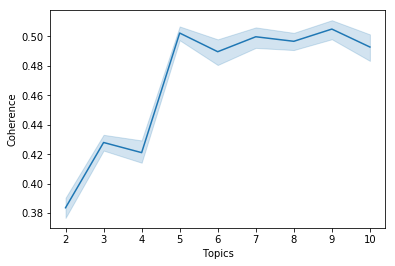

In [60]:
# visualize c_v score vs topics
sns.lineplot(data=df_result_75, x='Topics', y='Coherence');
# best # of topics = 5

In [62]:
# look for the best alpha and beta based on c_v score
df_result_75[df_result_75.Topics == 5].sort_values('Coherence', ascending=False)[:5]
# best alpha = asymmetric, best beta = 1, achieving 6% improvement over the baseline score

,Validation_Set,Topics,Alpha,Beta,Coherence
78,75% Corpus,5,asymmetric,1,0.527809
62,75% Corpus,5,0.01,1,0.518936
75,75% Corpus,5,symmetric,symmetric,0.510889
72,75% Corpus,5,symmetric,0.01,0.510680
73,75% Corpus,5,symmetric,0.1,0.505707


In [56]:
df_result_100 = df_result[df_result.Validation_Set == '100% Corpus']

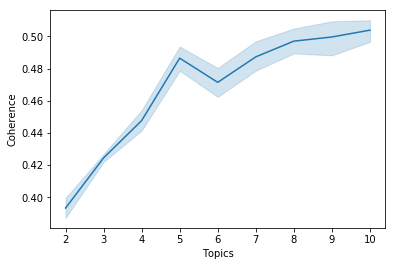

In [57]:
# visualize c_v score vs topics
sns.lineplot(data=df_result_100, x='Topics', y='Coherence');
# best # of topics = 5

In [63]:
# look for the best alpha and beta based on c_v score
df_result_100[df_result_100.Topics == 5].sort_values('Coherence', ascending=False)[:5]
# best alpha = asymmetric, best beta = 1, achieving 4% improvement over the baseline score

,Validation_Set,Topics,Alpha,Beta,Coherence
258,100% Corpus,5,asymmetric,1,0.515141
247,100% Corpus,5,0.1,symmetric,0.507848
241,100% Corpus,5,0.01,0.1,0.505819
246,100% Corpus,5,0.1,1,0.503461
242,100% Corpus,5,0.01,1,0.503092


In [66]:
lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=5, 
                                             random_state=100,
                                             chunksize=100,
                                             passes=10,
                                             alpha='asymmetric',
                                             eta=1)

In [67]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

/Users/fivecentsly/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.120629 -0.052818       1        1  44.838898
1      0.007727  0.168049       2        1  17.505642
3     -0.024488 -0.170050       3        1  15.484140
2      0.141454  0.037120       4        1  15.362620
4     -0.245322  0.017699       5        1   6.808698, topic_info=     Category         Freq         Term        Total  loglift  logprob
38    Default  1495.000000       cheese  1495.000000  30.0000  30.0000
57    Default  1209.000000        sauce  1209.000000  29.0000  29.0000
33    Default   737.000000        sugar   737.000000  28.0000  28.0000
20    Default   641.000000        cream   641.000000  27.0000  27.0000
65    Default  1040.000000       butter  1040.000000  26.0000  26.0000
14    Default  1075.000000       tomato  1075.000000  25.0000  25.0000
30    Default   547.000000        flour   547.000000  24.0000  24.0000
35    Default   974.000000        white   974.000000  23.0000  23.0000
11    Default  1331.000000        olive  1331.000000  22.0000  22.0000
95    Default   437.000000        brown   437.000000  21.0000  21.0000
31    Default   416.000000         milk   416.000000  20.0000  20.0000
62    Default   477.000000       potato   477.000000  19.0000  19.0000
58    Default   284.000000          soy   284.000000  18.0000  18.0000
29    Default   663.000000          egg   663.000000  17.0000  17.0000
165   Default   491.000000         bean   491.000000  16.0000  16.0000
10    Default  1933.000000          oil  1933.000000  15.0000  15.0000
107   Default   355.000000     parmesan   355.000000  14.0000  14.0000
27    Default   152.000000       baking   152.000000  13.0000  13.0000
48    Default   577.000000         beef   577.000000  12.0000  12.0000
295   Default   270.000000      italian   270.000000  11.0000  11.0000
203   Default   232.000000         soup   232.000000  10.0000  10.0000
3     Default  2238.000000        onion  2238.000000   9.0000   9.0000
37    Default   318.000000      cheddar   318.000000   8.0000   8.0000
106   Default   418.000000     mushroom   418.000000   7.0000   7.0000
13    Default  2694.000000         salt  2694.000000   6.0000   6.0000
32    Default   868.000000       powder   868.000000   5.0000   5.0000
249   Default   450.000000         rice   450.000000   4.0000   4.0000
162   Default   182.000000       ginger   182.000000   3.0000   3.0000
84    Default   546.000000      chicken   546.000000   2.0000   2.0000
26    Default   198.000000         sour   198.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
697    Topic5     8.739883          ice    13.100992   2.2822  -6.3387
98     Topic5    42.019436       raisin    65.316299   2.2459  -4.7685
28     Topic5    20.402889     cornmeal    31.717136   2.2458  -5.4909
708    Topic5     6.190400         flax     9.727589   2.2350  -6.6836
22     Topic5     6.276947  marshmallow     9.865867   2.2348  -6.6697
707    Topic5     6.127166    fashioned     9.643003   2.2335  -6.6939
337    Topic5     8.723925   applesauce    13.993654   2.2144  -6.3405
1180   Topic5     5.982001    miniature     9.666121   2.2071  -6.7178
104    Topic5    36.932980       walnut    60.415466   2.1948  -4.8975
97     Topic5    76.363037     cinnamon   132.419861   2.1365  -4.1711
150    Topic5    64.285362        apple   118.285416   2.0772  -4.3433
33     Topic5   297.793732        sugar   737.140503   1.7806  -2.8102
30     Topic5   187.891373        flour   547.534363   1.6174  -3.2707
95     Topic5   131.176941        brown   437.240509   1.4830  -3.6300
96     Topic5    24.659184         chip    51.427177   1.9520  -5.3014
326    Topic5    28.983835        wheat    64.119308   1.8930  -5.1399
65     Topic5   176.612747       butter  1040.293701   0.9137  -3.3326
75     Topic5    48.795734     softened   159.668716   1.5015  -4.6189
35     Topic5   158.303970   

In [68]:
pyLDAvis.save_html(LDAvis_prepared, 'recipe_lda.html')

In [69]:
# Print the keyword in the 10 topics
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

[(0,
  '0.083*"pepper" + 0.054*"salt" + 0.047*"oil" + 0.039*"black" + 0.037*"olive" '
  '+ 0.037*"garlic" + 0.035*"onion" + 0.027*"red" + 0.018*"white" + '
  '0.017*"tomato"'),
 (1,
  '0.050*"cream" + 0.043*"onion" + 0.041*"cheese" + 0.038*"butter" + '
  '0.036*"salt" + 0.035*"pepper" + 0.027*"potato" + 0.026*"flour" + '
  '0.025*"milk" + 0.022*"black"'),
 (2,
  '0.080*"cheese" + 0.045*"tomato" + 0.029*"pepper" + 0.026*"sauce" + '
  '0.025*"onion" + 0.024*"garlic" + 0.024*"bean" + 0.023*"parmesan" + '
  '0.019*"italian" + 0.016*"black"'),
 (3,
  '0.069*"sauce" + 0.028*"sugar" + 0.027*"garlic" + 0.025*"oil" + '
  '0.025*"pepper" + 0.025*"soy" + 0.023*"brown" + 0.022*"onion" + '
  '0.021*"powder" + 0.019*"water"'),
 (4,
  '0.060*"sugar" + 0.038*"flour" + 0.036*"butter" + 0.032*"white" + '
  '0.030*"baking" + 0.030*"salt" + 0.027*"brown" + 0.024*"egg" + 0.017*"milk" '
  '+ 0.016*"vanilla_extract"')]


In [70]:
# create a df to show lda matrix
lda_dict = {0: [], 1: [], 2: [], 3: [], 4: []}

for _ in range(len(doc_lda)):
    lda_dict[0].append(0)
    lda_dict[1].append(0)
    lda_dict[2].append(0)
    lda_dict[3].append(0)
    lda_dict[4].append(0)

# create a df filled with 0
lda_matrix = pd.DataFrame(lda_dict)

# fill the prop of topic for each row
for i, row in enumerate(doc_lda):
    for j, (topic, prop_topic) in enumerate(row):
        lda_matrix.loc[i, topic] = prop_topic

In [71]:
lda_matrix.head()

,0,1,2,3,4
0,0.924249,0.026679,0.019934,0.015853,0.013285
1,0.948437,0.017808,0.013628,0.010946,0.000000
2,0.034310,0.282062,0.017625,0.014268,0.651734
3,0.041864,0.019712,0.014704,0.011895,0.911825
4,0.269594,0.412651,0.222569,0.000000,0.087669


In [75]:
# add recipe name
lda_matrix = lda_matrix.merge(df_lda, left_index=True, right_index=True, how='inner')

# set title as index
lda_matrix.set_index('title', inplace=True)

lda_matrix.head()

,0,1,2,3,4,ingredient
title,,,,,,
1 Pea Salad Most Requested,0.924249,0.026679,0.019934,0.015853,0.013285,petite pea smoke almond onion mayonnaise black...
10 Minute Tomato Basil Salad,0.948437,0.017808,0.013628,0.010946,0.000000,tomato basil extra virgin olive oil red wine v...
5 Cup Salad,0.034310,0.282062,0.017625,0.014268,0.651734,mini marshmallow coconut mandarin orange pinea...
5 Minute Microwave Cornbread,0.041864,0.019712,0.014704,0.011895,0.911825,flour cornmeal white sugar baking powder salt ...
7 Layer Salad,0.269594,0.412651,0.222569,0.000000,0.087669,head lettuce torn cucumber pea cheddar cheese ...


In [89]:
# assign topic names using my judgement
lda_matrix.sort_values(by=0, ascending=False)[:20]
# topic 0 looks like veggie and seafood 

,0,1,2,3,4,ingredient
title,,,,,,
Quick And Easy Paella,0.989584,0.0,0.0,0.0,0.0,saffron broth shrimp deveined shell reserved o...
Grilled Salmon With Bacon And Corn Relish,0.989284,0.0,0.0,0.0,0.0,bacon crosswise ear white corn green onion whi...
Chef Johns Fresh Salmon Cakes,0.989216,0.0,0.0,0.0,0.0,extra virgin olive oil onion red bell pepper c...
Shrimp Scampi With Pasta,0.988616,0.0,0.0,0.0,0.0,linguine pasta butter extra virgin olive oil s...
Chef Johns Shrimp Fra Diavolo,0.987332,0.0,0.0,0.0,0.0,extra shrimp deveined tail left olive oil need...
Cindys Jambalaya,0.987237,0.0,0.0,0.0,0.0,olive oil smoked sausage conecuh onion green b...
Ham And Beans And More,0.987090,0.0,0.0,0.0,0.0,great northern bean sorted water celery onion ...
Slow Cooker Spicy Black Eyed Peas,0.986113,0.0,0.0,0.0,0.0,water chicken bouillon black eyed pea sorted o...
Sea Bass Cuban Style,0.985701,0.0,0.0,0.0,0.0,extra virgin olive oil white onion garlic seed...


In [90]:
lda_matrix.sort_values(by=1, ascending=False)[:20]
# topic 1 looks like soup

,0,1,2,3,4,ingredient
title,,,,,,
Simple Hamburger Stroganoff,0.010306,0.976390,0.0,0.0,0.0,egg noodle beef brown gravy cream cheese mushr...
Chef Johns Shepherds Pie,0.011235,0.976209,0.0,0.0,0.0,yukon gold potato garlic beef flour beef broth...
Oven Pot Roast,0.012294,0.972601,0.0,0.0,0.0,flour black pepper rump roast butter envelope ...
Leftover Ham N Potato Casserole,0.013774,0.969986,0.0,0.0,0.0,potato butter ham onion butter flour milk salt...
Salisbury Steak With Mushrooms,0.014287,0.969457,0.0,0.0,0.0,beef bread onion egg salt black pepper beef br...
Crawfish Chowder,0.016723,0.965729,0.0,0.0,0.0,butter green onion butter crawfish cleaned con...
Turkey Wild Rice Soup,0.016155,0.965567,0.0,0.0,0.0,condensed chicken broth water green onion unco...
All Day Venison Pot Roast,0.016934,0.963960,0.0,0.0,0.0,onion carrot portobello mushroom venison rump ...
Hearty Ranch And Bacon Potato Soup,0.016939,0.963113,0.0,0.0,0.0,smoked bacon onion celery chicken broth potato...


In [91]:
lda_matrix.sort_values(by=2, ascending=False)[:20]
# topic 2 looks like Italian cuisine

,0,1,2,3,4,ingredient
title,,,,,,
Lasagna Stuffed Shells,0.000000,0.000000,0.980451,0.0,0.0,pasta shell beef onion tomato paste tomato sau...
Stuffed Shells I,0.000000,0.000000,0.977074,0.0,0.0,pasta shell curd cottage cheese mozzarella che...
Tater Tot Taco Casserole,0.010127,0.000000,0.975653,0.0,0.0,beef onion garlic taco seasoning bag mexican c...
Stuffed Shells Iii,0.011118,0.000000,0.974534,0.0,0.0,pasta shell egg ricotta cheese mozzarella chee...
Pasta Salad A La Honeybear,0.012196,0.000000,0.974311,0.0,0.0,tri rotini pasta red onion roasted red pepper ...
Easy Lasagna Ii,0.011380,0.000000,0.974256,0.0,0.0,beef jar spaghetti sauce cottage cheese mozzar...
Manicotti,0.011743,0.000000,0.973117,0.0,0.0,ricotta cheese mozzarella cheese parmesan chee...
Healthier Worlds Best Lasagna,0.014101,0.000000,0.967444,0.0,0.0,turkey sausage turkey onion garlic tomato toma...
Bobs Awesome Lasagna,0.014636,0.000000,0.966803,0.0,0.0,lasagna noodle beef onion salt garlic salt jar...


In [92]:
lda_matrix.sort_values(by=3, ascending=False)[:20]
# topic 3 looks like Asian cuisine

,0,1,2,3,4,ingredient
title,,,,,,
Mongolian Beef And Spring Onions,0.000000,0.000000,0.0,0.980179,0.0,vegetable oil garlic ginger root soy sauce wat...
Zen Garden Pad Thai,0.000000,0.000000,0.0,0.978198,0.0,naturally brewed soy sauce lime juice brown su...
Penang Pork Satay,0.000000,0.000000,0.0,0.977000,0.0,turmeric root across grain turmeric ginger roo...
Cedar Planked Salmon,0.010936,0.000000,0.0,0.973976,0.0,cedar plank vegetable oil rice vinegar sesame ...
Chef Johns Hoisin Barbeque Pork Ribs,0.011696,0.000000,0.0,0.971979,0.0,marinade pineapple juice hoisin sauce hot chil...
Bulgogi Beef Korean Style Barbecue,0.013623,0.000000,0.0,0.971156,0.0,beef short rib across grain garlic yellow onio...
Carries Pad Thai Salad,0.012294,0.000000,0.0,0.970990,0.0,rice noodle white sugar water lime soy sauce f...
Chinese Pork Dumplings,0.012146,0.000000,0.0,0.969972,0.0,soy sauce rice vinegar chinese chive sesame se...
Miso Maple Glazed Salmon,0.013317,0.000000,0.0,0.969687,0.0,yellow miso paste rice vinegar maple syrup hot...


In [94]:
lda_matrix.sort_values(by=4, ascending=False)[:20]
# topic 4 looks like bread and cookies

,0,1,2,3,4,ingredient
title,,,,,,
Classic Cinnamon Rolls,0.000000,0.000000,0.0,0.0,0.977683,roll potato reserved potato water butter marga...
Seeduction Bread,0.011171,0.000000,0.0,0.0,0.972620,warm water molasses honey envelope active yea...
Whole Grain Breakfast Cookies,0.012673,0.000000,0.0,0.0,0.968328,walnut old fashioned rolled oat instant wheat ...
Pumpkin Muffins With Streusel Topping,0.012966,0.000000,0.0,0.0,0.967334,flour rolled oat pumpkin pie spice baking soda...
Crunchy Wheat And Rye,0.014023,0.000000,0.0,0.0,0.963711,water honey butter softened bread flour wheat ...
Danish Spiced Rye Bread Sigtebrod,0.014316,0.000000,0.0,0.0,0.963552,milk water butter light molasses white sugar o...
Bird Seed Energy Bars,0.014618,0.000000,0.0,0.0,0.963347,old fashioned rolled oat brown sugar wheat ger...
Hearty Multigrain Bread,0.014859,0.000000,0.0,0.0,0.961979,water butter softened salt sunflower seed sesa...
October Oatmeal Pumpkin Muffins,0.014883,0.010190,0.0,0.0,0.961082,stick spray flour wheat flour white sugar salt...


In [95]:
# drop ingredient  
lda_matrix.drop('ingredient', axis=1, inplace=True)

# change column name
lda_matrix.columns = ['veggie_seafood', 'soup', 'italian', 'asian', 'bread_cookie']

lda_matrix.head()

,veggie_seafood,soup,italian,asian,bread_cookie
title,,,,,
1 Pea Salad Most Requested,0.924249,0.026679,0.019934,0.015853,0.013285
10 Minute Tomato Basil Salad,0.948437,0.017808,0.013628,0.010946,0.000000
5 Cup Salad,0.034310,0.282062,0.017625,0.014268,0.651734
5 Minute Microwave Cornbread,0.041864,0.019712,0.014704,0.011895,0.911825
7 Layer Salad,0.269594,0.412651,0.222569,0.000000,0.087669


In [96]:
# save lda_matrix
lda_matrix.to_csv('recipe_ida.csv')

In [97]:
lda_matrix.shape

(3954, 5)

References: 

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0